# AML flow cytometry analysis

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
from fcvae_dataset import load_data
from fcvae_model import VAE, Encoder, Decoder, Classifier
from fcvae_trainer import fcTrainer
from fcvae_plot import CellPlotter2D, plot_joint_aml, plot_shared_markers_aml, plot_imputed_values_set
from umap import UMAP
import flowkit as fk
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("Device:", device)

Torch version: 1.2.0
Device: cpu


## 1. Load data

In [2]:
filepath1 = "/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/data_files1/"

batch_size = 256         # number of data points in each batch
n_epochs = 20           # times to run the model on complete data
input_dim = 7     # size of each input
hidden_dim = 128        # hidden dimension
latent_dim = 4        # latent vector dimension
lr = 1e-3              # learning rate
n_head = 6
n_shared = 3
missing = 20

datasets = load_data(filepath1)

input_dim_list = []
output_dim_list = []
train_iterators = []
test_iterators = []
train_cells = 0
test_cells = 0
for tube in datasets:
    input_dim_list.append(len(tube[0].columns))
    output_dim_list.append(len(tube[0].columns)+missing)
    train_iterators.append(tube[3])
    test_iterators.append(tube[4])
    train_cells += tube[1].nb_cells
    test_cells += tube[2].nb_cells

N_train = int(train_cells/n_head)
N_test = int(test_cells/n_head)
print('Training set size:', N_train)
print('Test set size:', N_test)

Training set size: 27000
Test set size: 3000


## 2. Create a model

In [3]:
# Encoder
encoder = Encoder(n_head, input_dim_list, hidden_dim, latent_dim)

# Decoder
decoder = Decoder(latent_dim, hidden_dim, output_dim_list, n_head)

# VAE
model = VAE(encoder, decoder).to(device)

# Discriminator
discriminator = Classifier(latent_dim, hidden_dim, n_head) 

print("n_tubes:", n_head)
print("n_shared:", n_shared)
print("n_other:", missing)
print("output_dim:", output_dim_list[0])
print("encoder_dims:", input_dim_list)

n_tubes: 6
n_shared: 3
n_other: 20
output_dim: 27
encoder_dims: [7, 7, 7, 7, 7, 7]


## 3. Train the model

In [4]:
# Create trainer
trainer = fcTrainer(
            model,
            discriminator,
            train_loaders = train_iterators,
            test_loaders = test_iterators,
            N_train = N_train,
            N_test = N_test,
            dloss_weight = 20,
            device = device,
            n_epochs = n_epochs,
            print_frequency = 1,
            optimizer_kwargs = dict(lr = lr)
)

13/03/2020 09:52:21 [INFO]: Creating a trainer on device `cpu`


In [5]:
# Run training
trainer.train()

13/03/2020 09:52:21 [INFO]: TRAINING STARTED (n_epochs = 20).
13/03/2020 09:53:06 [INFO]: Epoch: 00, VAE loss: (214.15923, 84.85411), Discriminator loss: (2.60984, 3.21776)
13/03/2020 09:53:50 [INFO]: Epoch: 01, VAE loss: (104.0506, 74.16717), Discriminator loss: (1.46341, 3.30853)
13/03/2020 09:54:34 [INFO]: Epoch: 02, VAE loss: (91.42966, 65.98149), Discriminator loss: (1.17852, 3.30778)
13/03/2020 09:55:19 [INFO]: Epoch: 03, VAE loss: (85.38043, 64.49405), Discriminator loss: (1.12344, 3.27366)
13/03/2020 09:56:03 [INFO]: Epoch: 04, VAE loss: (80.89529, 58.96976), Discriminator loss: (1.13379, 3.31603)
13/03/2020 09:56:47 [INFO]: Epoch: 05, VAE loss: (78.42891, 57.81674), Discriminator loss: (1.17939, 3.34405)
13/03/2020 09:57:31 [INFO]: Epoch: 06, VAE loss: (75.52226, 55.24669), Discriminator loss: (1.19492, 3.17972)
13/03/2020 09:58:15 [INFO]: Epoch: 07, VAE loss: (73.72767, 56.8121), Discriminator loss: (1.19899, 3.32776)
13/03/2020 09:58:58 [INFO]: Epoch: 08, VAE loss: (72.00085

## 4. Visualization

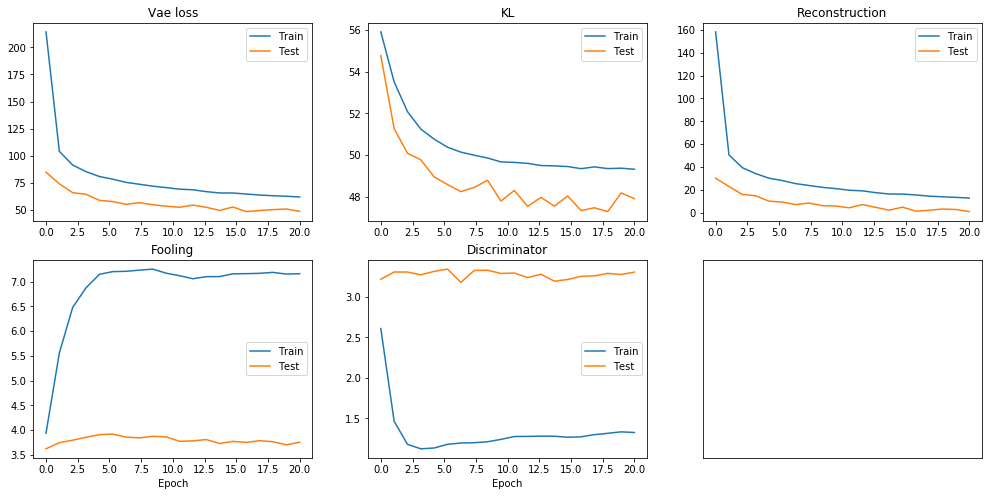

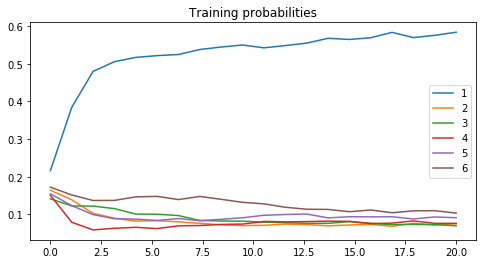

In [9]:
trainer.plot()
trainer.plot_probs()
# no test curves?

/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/hiltunh3/.conda/envs/scvi/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../.

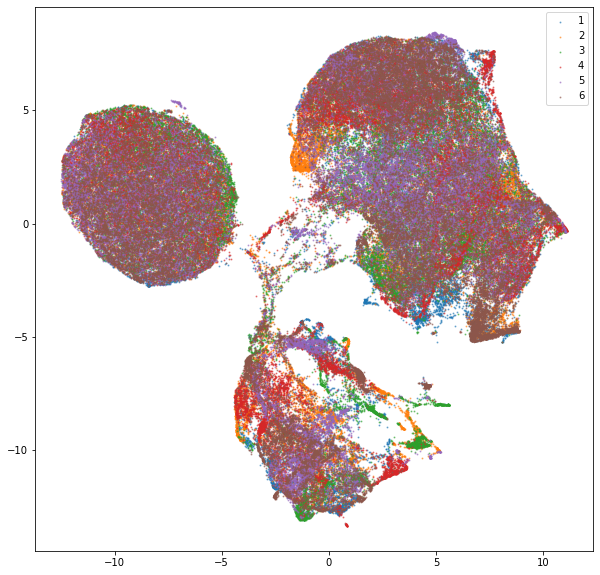

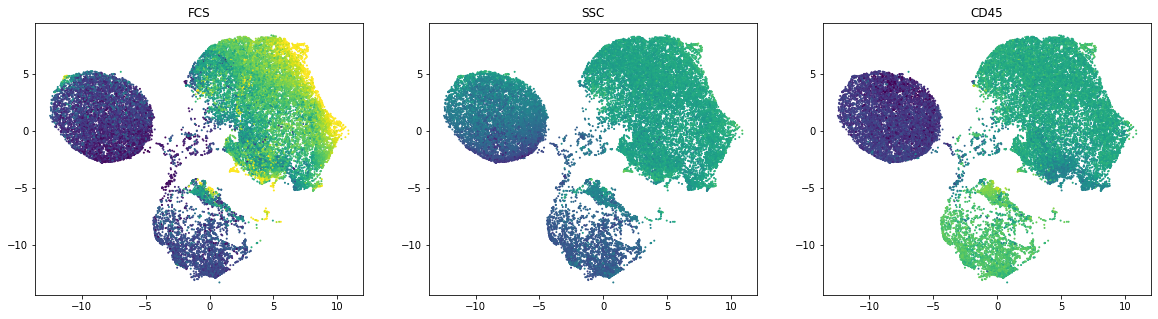

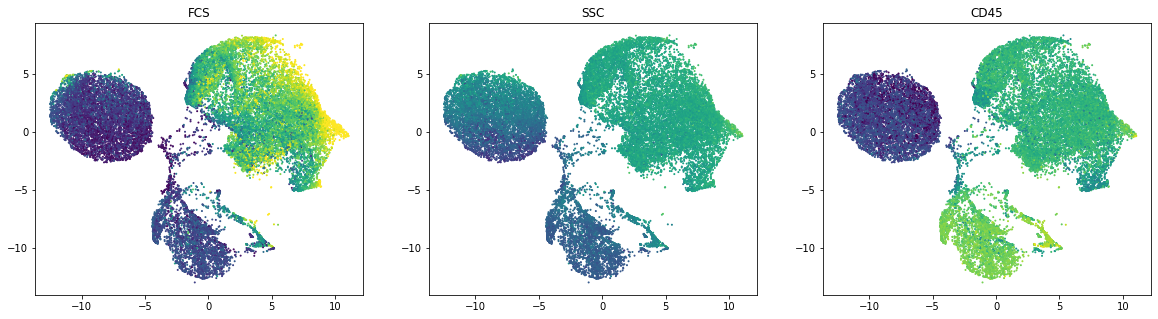

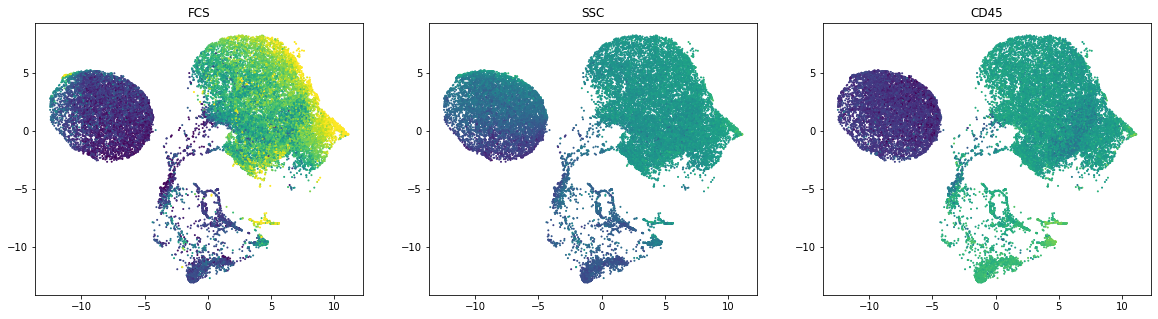

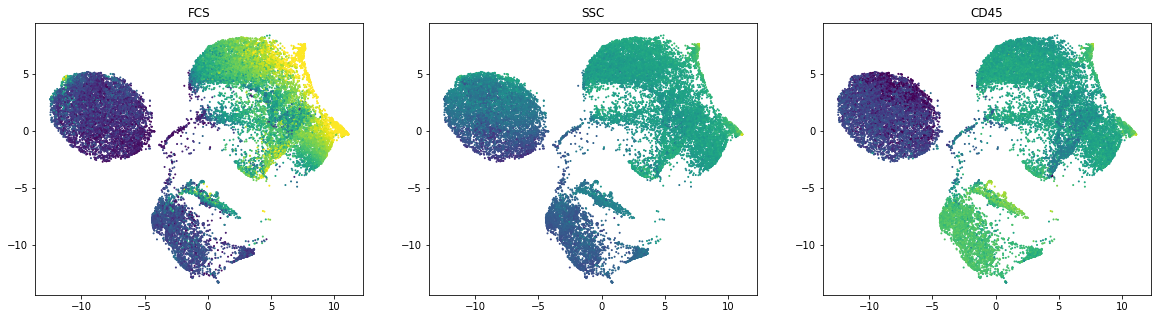

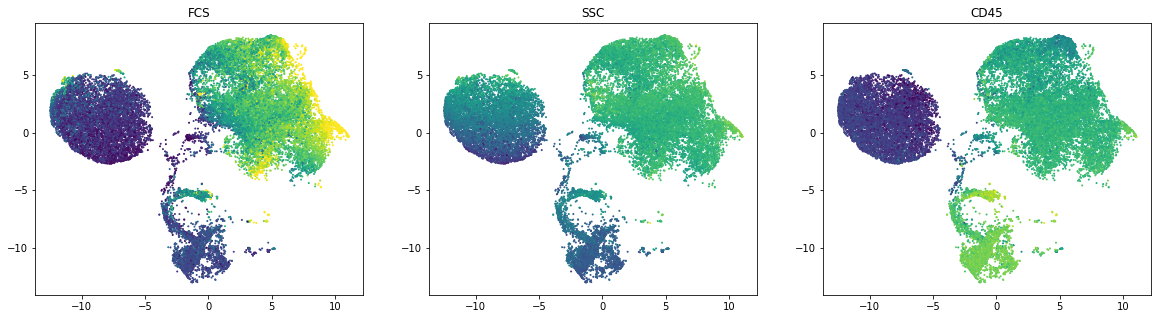

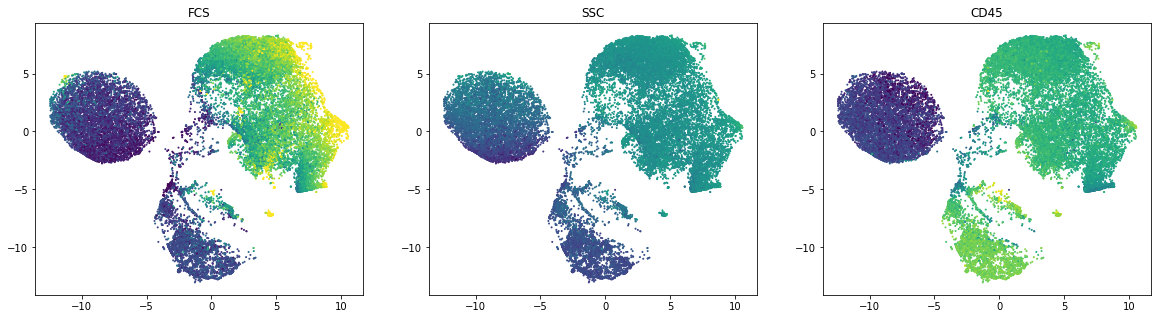

In [7]:
latents = []

trainer.vae.eval()
for i in range(n_head):
    data = Variable(torch.from_numpy(datasets[i][0].to_numpy()), requires_grad=False)
    latents.append(model.get_z(data.float(), i).data.numpy())
latent2d = UMAP().fit_transform(np.concatenate(latents))

plot_joint_aml(trainer, latent2d, latents)
plot_shared_markers_aml(trainer, latent2d, latents, datasets)

## 5. Imputation

[['HLA-DR-FITC', 'CD117-PE', 'CD34-PC5', 'CD38-PC7'], ['Kappa-FITC', 'Lambda-PE', 'CD19-PC5', 'CD20-PC7'], ['CD7-FITC', 'CD4-PE', 'CD8-PC5', 'CD2-PC7'], ['CD15-FITC', 'CD13-PE', 'CD16-PC5', 'CD56-PC7'], ['CD5-FITC', 'CD19-PE', 'CD3-PC5', 'CD10-PC7'], ['CD14-FITC', 'CD11c-PE', 'CD64-PC5', 'CD33-PC7']]


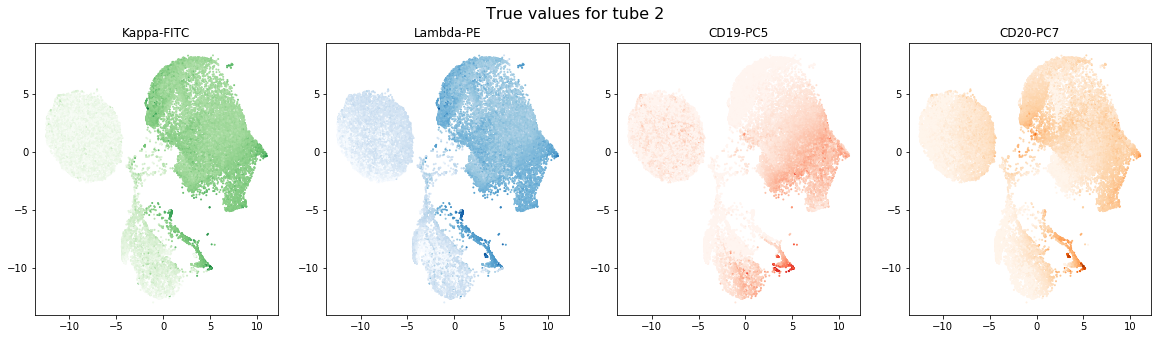

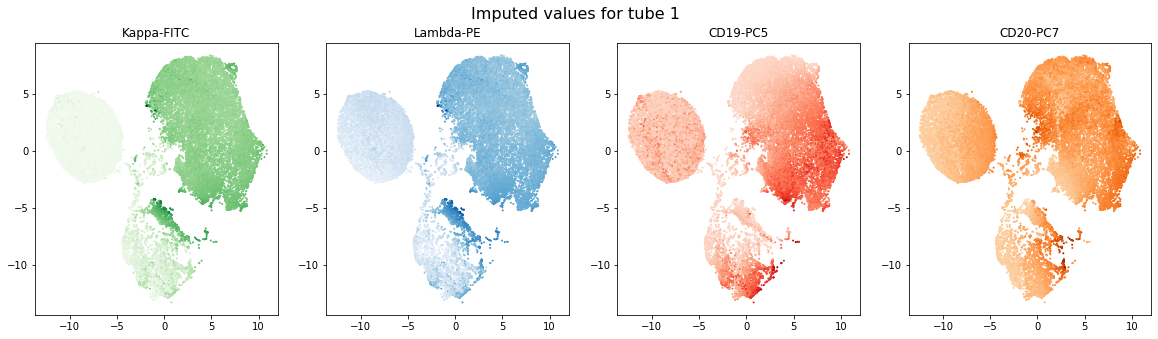

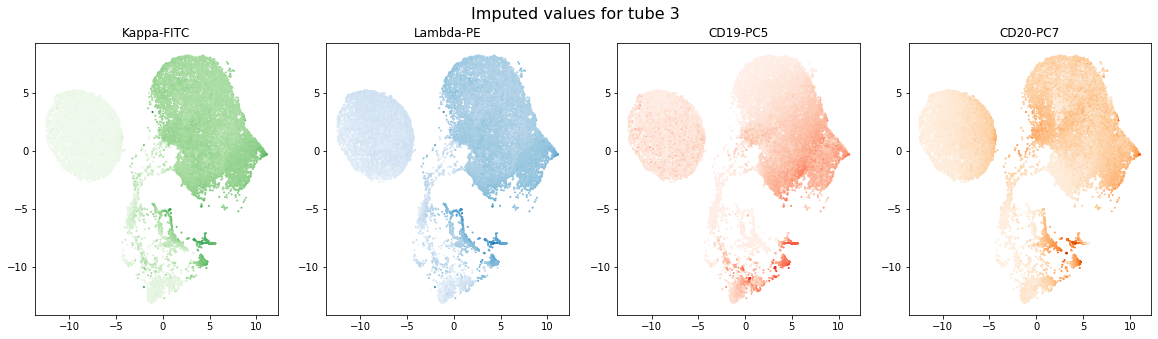

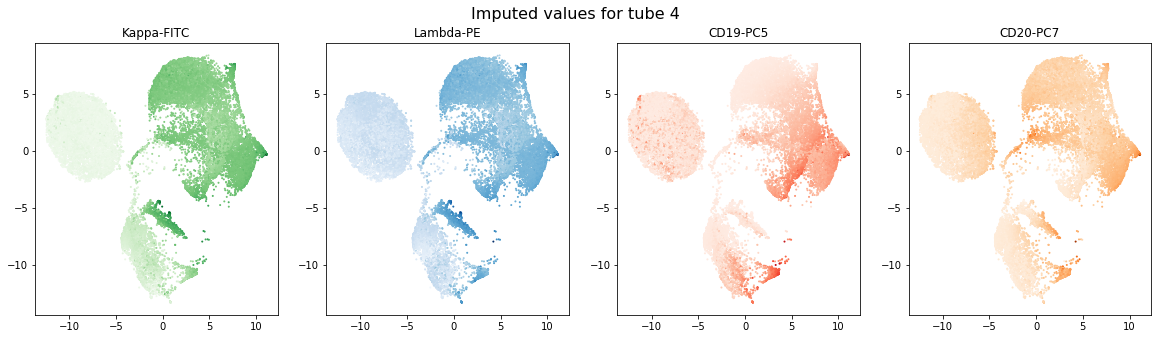

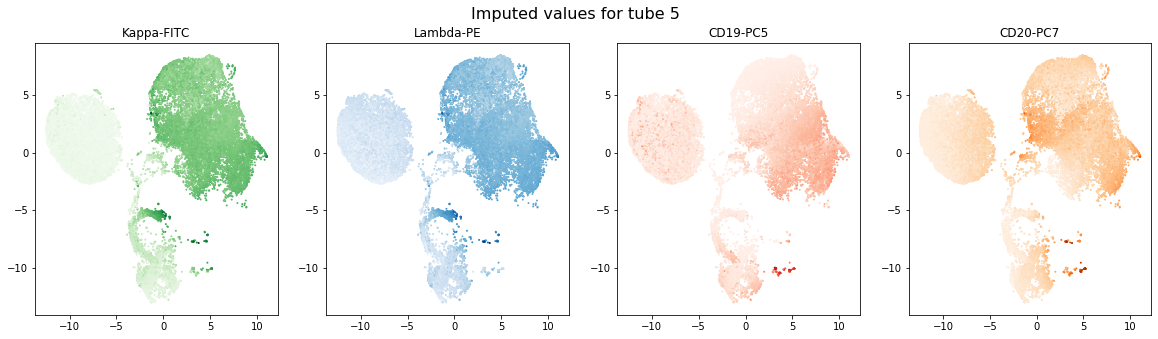

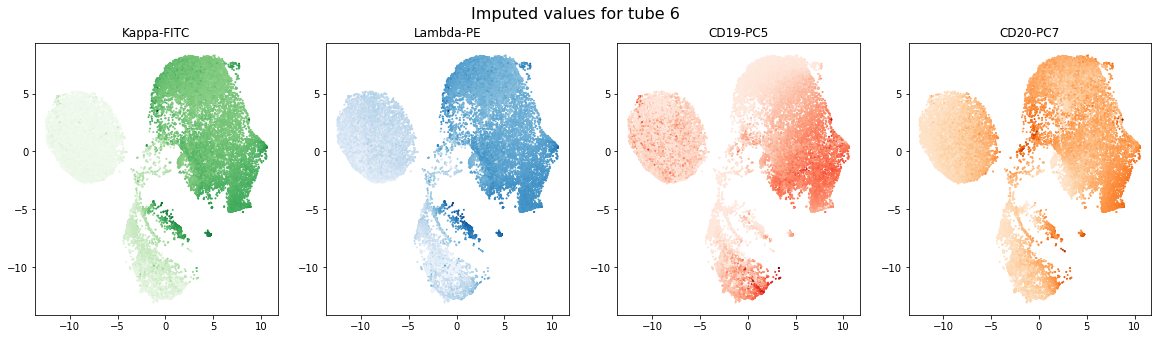

In [10]:
# marker names 
files = glob.glob(filepath1 + "*.txt")
titles = []
for i in range(len(files)):
    fcs = files[i][-8:-4]
    fcs_path = '/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Data/AML/FCS/'+fcs+'.FCS'
    sample = fk.Sample(fcs_path, subsample_count=None)
    features = sample.pns_labels[2:7]
    features.pop(2)
    titles.append(features)
print(titles) 

# visualize one set of imputed values
#plot_imputed_values(trainer, latent2d, latents, datasets, titles) # for 2 tubes only
tube_id = 1
plot_imputed_values_set(trainer, tube_id, latent2d, latents, datasets, titles[tube_id])

## 6. Validation metrics

In [17]:
def validation_accuracy(model, discriminator, test_iterators):
    model.eval()
    discriminator.eval()
    probs = []
    for tensors in test_iterators:
        ps = []
        for head_id, batch in enumerate(tensors):
            z = model.get_z(batch.float(), head_id)
            p = discriminator.classify(z)
            ps.append(p)
        pr = torch.cat(ps).cpu().detach().numpy()
        probs.append(pr)
    return probs

def validation_loss(test_iterators, model, input_dim_list):
    # set the evaluation mode
    model.eval()
    n_head = len(input_dim_list)
    # test loss for the data
    test_losses = []
    
    for tensors in test_iterators:
        for head_id, x in enumerate(tensors): 
            # reshape the data
            x = x.view(-1, input_dim_list[head_id]) 
            x = x.float()
            x = x.to(device)

            # forward pass
            x_sample, z_mu, z_var = model(x, head_id)

            loss, recs, kls = model.loss(x_sample, x, z_mu, z_var, head_id)
            test_losses.append(loss)
    sum_loss = torch.stack(test_losses).sum()

    return sum_loss

In [9]:
runs = 5
accuracies = []
val_losses = []
for i in range(runs):
    trainer.train()
    acc = validation_accuracy(model, discriminator, zip(*test_iterators))
    acc = [item for sublist in acc for item in sublist]
    acc = [item for sublist in acc for item in sublist]
    correct = 0
    probs1 = acc[::n_head]
    for i in probs1[:N_test]:
        if i > 1/n_head:
            correct += 1
    for i in probs1[N_test:]:
        if i < 1/n_head:
            correct += 1

    accuracy = correct/len(acc[::n_head])
    accuracies.append(accuracy)
    val_loss = validation_loss(zip(*test_iterators), model, input_dim_list)/N_test
    val_losses.append(val_loss)
print(accuracies)
print(val_losses)

05/03/2020 16:21:50 [INFO]: TRAINING STARTED (n_epochs = 20).
05/03/2020 16:22:05 [INFO]: Epoch: 00, VAE loss: (14.69539, 53.53969), Discriminator loss: (0.14106, 0.21244)
05/03/2020 16:22:21 [INFO]: Epoch: 01, VAE loss: (14.91793, 56.14806), Discriminator loss: (0.13804, 0.21658)
05/03/2020 16:22:36 [INFO]: Epoch: 02, VAE loss: (14.73808, 52.50716), Discriminator loss: (0.1323, 0.2142)
05/03/2020 16:22:51 [INFO]: Epoch: 03, VAE loss: (14.77768, 51.6382), Discriminator loss: (0.13447, 0.215)
05/03/2020 16:23:06 [INFO]: Epoch: 04, VAE loss: (14.71131, 56.18731), Discriminator loss: (0.14064, 0.21941)
05/03/2020 16:23:21 [INFO]: Epoch: 05, VAE loss: (14.76837, 55.6696), Discriminator loss: (0.12994, 0.21401)
05/03/2020 16:23:36 [INFO]: Epoch: 06, VAE loss: (14.702, 54.27815), Discriminator loss: (0.13424, 0.2075)
05/03/2020 16:23:51 [INFO]: Epoch: 07, VAE loss: (14.58581, 52.67349), Discriminator loss: (0.13525, 0.21366)
05/03/2020 16:24:07 [INFO]: Epoch: 08, VAE loss: (14.57868, 53.5473

05/03/2020 16:41:15 [INFO]: Epoch: 12, VAE loss: (13.79459, 50.22748), Discriminator loss: (0.14143, 0.20657)
05/03/2020 16:41:30 [INFO]: Epoch: 13, VAE loss: (13.7921, 52.42924), Discriminator loss: (0.13894, 0.22764)
05/03/2020 16:41:46 [INFO]: Epoch: 14, VAE loss: (13.75285, 50.07374), Discriminator loss: (0.14646, 0.21207)
05/03/2020 16:42:02 [INFO]: Epoch: 15, VAE loss: (13.81958, 49.95997), Discriminator loss: (0.14265, 0.21391)
05/03/2020 16:42:18 [INFO]: Epoch: 16, VAE loss: (13.78952, 51.67304), Discriminator loss: (0.13913, 0.21297)
05/03/2020 16:42:36 [INFO]: Epoch: 17, VAE loss: (13.83414, 53.05039), Discriminator loss: (0.14018, 0.21758)
05/03/2020 16:42:51 [INFO]: Epoch: 18, VAE loss: (13.8011, 50.01506), Discriminator loss: (0.13965, 0.22742)
05/03/2020 16:43:06 [INFO]: Epoch: 19, VAE loss: (13.75074, 50.62989), Discriminator loss: (0.13949, 0.22457)
05/03/2020 16:43:06 [INFO]: TRAINING FINISHED.

05/03/2020 16:43:06 [INFO]: TRAINING STARTED (n_epochs = 20).
05/03/2020 1

In [10]:
print(np.mean(accuracies))
print(torch.mean(torch.stack(val_losses)))

0.49870000000000003
tensor(50.6794, grad_fn=<MeanBackward0>)


In [18]:
# optimal hyperparameters

ks = np.arange(0,200,10)
print(ks)
accuracies = []
val_losses = []
for i in ks:
    batch_size = 256         # number of data points in each batch
    n_epochs = 20           # times to run the model on complete data
    hidden_dim = 128        # hidden dimension
    latent_dim = 4        # latent vector dimension
    lr = 1e-3              # learning rate
    n_head = 6
    n_shared = 3
    missing = 20

    datasets = load_data(filepath1)

    input_dim_list = []
    output_dim_list = []
    train_iterators = []
    test_iterators = []
    train_cells = 0
    test_cells = 0
    for tube in datasets:
        input_dim_list.append(len(tube[0].columns))
        output_dim_list.append(len(tube[0].columns)+missing)
        train_iterators.append(tube[3])
        test_iterators.append(tube[4])
        train_cells += tube[1].nb_cells
        test_cells += tube[2].nb_cells
    
    encoder = Encoder(n_head, input_dim_list, hidden_dim, latent_dim)
    decoder = Decoder(latent_dim, hidden_dim, output_dim_list, n_head)
    model = VAE(encoder, decoder).to(device)
    discriminator = Classifier(latent_dim, hidden_dim, n_head) 

    trainer = fcTrainer(
            model,
            discriminator,
            train_loaders = train_iterators,
            test_loaders = test_iterators,
            N_train = N_train,
            N_test = N_test,
            dloss_weight = i,
            device = device,
            n_epochs = n_epochs,
            print_frequency = 1,
            optimizer_kwargs = dict(lr = lr)
    )

    trainer.train()
    acc = validation_accuracy(model, discriminator, zip(*test_iterators))
    acc = [item for sublist in acc for item in sublist]
    acc = [item for sublist in acc for item in sublist]
    correct = 0
    probs1 = acc[::n_head]
    for i in probs1[:N_test]:
        if i > 1/n_head:
            correct += 1
    for i in probs1[N_test:]:
        if i < 1/n_head:
            correct += 1

    accuracy = correct/len(acc[::n_head])
    accuracies.append(accuracy)
    val_loss = validation_loss(zip(*test_iterators), model, input_dim_list)/N_test
    val_losses.append(val_loss)
print(accuracies)
print(val_losses)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190]
12/03/2020 14:32:55 [INFO]: Creating a trainer on device `cpu`
12/03/2020 14:32:55 [INFO]: TRAINING STARTED (n_epochs = 20).
12/03/2020 14:33:42 [INFO]: Epoch: 00, VAE loss: (197.70561, 82.49043), Discriminator loss: (0.0, 0.0)
12/03/2020 14:34:30 [INFO]: Epoch: 01, VAE loss: (97.72819, 68.79083), Discriminator loss: (0.0, 0.0)
12/03/2020 14:35:17 [INFO]: Epoch: 02, VAE loss: (87.5001, 62.98782), Discriminator loss: (0.0, 0.0)
12/03/2020 14:36:04 [INFO]: Epoch: 03, VAE loss: (81.68327, 60.20399), Discriminator loss: (0.0, 0.0)
12/03/2020 14:36:55 [INFO]: Epoch: 04, VAE loss: (77.79821, 59.01276), Discriminator loss: (0.0, 0.0)
12/03/2020 14:37:42 [INFO]: Epoch: 05, VAE loss: (75.20314, 56.60911), Discriminator loss: (0.0, 0.0)
12/03/2020 14:38:31 [INFO]: Epoch: 06, VAE loss: (72.64721, 53.51071), Discriminator loss: (0.0, 0.0)
12/03/2020 14:39:34 [INFO]: Epoch: 07, VAE loss: (70.70815, 57.42815), Discrim

12/03/2020 15:26:45 [INFO]: Epoch: 10, VAE loss: (67.80102, 55.10533), Discriminator loss: (2.54772, 4.99005)
12/03/2020 15:27:30 [INFO]: Epoch: 11, VAE loss: (66.82409, 56.43219), Discriminator loss: (2.58269, 4.92326)
12/03/2020 15:28:14 [INFO]: Epoch: 12, VAE loss: (65.64885, 52.85851), Discriminator loss: (2.61688, 4.90892)
12/03/2020 15:28:59 [INFO]: Epoch: 13, VAE loss: (64.73018, 54.99445), Discriminator loss: (2.63709, 4.90986)
12/03/2020 15:29:44 [INFO]: Epoch: 14, VAE loss: (64.02485, 58.82941), Discriminator loss: (2.62066, 4.99692)
12/03/2020 15:30:29 [INFO]: Epoch: 15, VAE loss: (62.3858, 55.12082), Discriminator loss: (2.60968, 4.94303)
12/03/2020 15:31:14 [INFO]: Epoch: 16, VAE loss: (62.79314, 53.52397), Discriminator loss: (2.66364, 4.90519)
12/03/2020 15:31:58 [INFO]: Epoch: 17, VAE loss: (61.83708, 52.72564), Discriminator loss: (2.62152, 4.91567)
12/03/2020 15:32:43 [INFO]: Epoch: 18, VAE loss: (60.75809, 58.59579), Discriminator loss: (2.69215, 4.9284)
12/03/2020 1

12/03/2020 16:21:09 [INFO]: Creating a trainer on device `cpu`
12/03/2020 16:21:09 [INFO]: TRAINING STARTED (n_epochs = 20).
12/03/2020 16:21:57 [INFO]: Epoch: 00, VAE loss: (198.52322, 91.29325), Discriminator loss: (9.55764, 11.35778)
12/03/2020 16:22:45 [INFO]: Epoch: 01, VAE loss: (99.23662, 71.70989), Discriminator loss: (6.74581, 11.3067)
12/03/2020 16:23:32 [INFO]: Epoch: 02, VAE loss: (88.51396, 66.80468), Discriminator loss: (6.84317, 11.22452)
12/03/2020 16:24:20 [INFO]: Epoch: 03, VAE loss: (84.06334, 75.78106), Discriminator loss: (6.93134, 11.09168)
12/03/2020 16:25:21 [INFO]: Epoch: 04, VAE loss: (80.26345, 62.23079), Discriminator loss: (6.84174, 11.07739)
12/03/2020 16:26:12 [INFO]: Epoch: 05, VAE loss: (77.63262, 61.73223), Discriminator loss: (6.88902, 11.1594)
12/03/2020 16:27:01 [INFO]: Epoch: 06, VAE loss: (75.35466, 60.34536), Discriminator loss: (6.95778, 11.3499)
12/03/2020 16:27:58 [INFO]: Epoch: 07, VAE loss: (73.51279, 55.47777), Discriminator loss: (6.95751,

12/03/2020 17:14:25 [INFO]: Epoch: 08, VAE loss: (72.08422, 60.86815), Discriminator loss: (12.02594, 16.52595)
12/03/2020 17:15:10 [INFO]: Epoch: 09, VAE loss: (71.06121, 58.72962), Discriminator loss: (12.0535, 16.42268)
12/03/2020 17:15:55 [INFO]: Epoch: 10, VAE loss: (69.63145, 61.29383), Discriminator loss: (12.0675, 16.5034)
12/03/2020 17:16:39 [INFO]: Epoch: 11, VAE loss: (68.81514, 57.31305), Discriminator loss: (12.07452, 16.26661)
12/03/2020 17:17:24 [INFO]: Epoch: 12, VAE loss: (67.71677, 58.06394), Discriminator loss: (12.15682, 16.49979)
12/03/2020 17:18:09 [INFO]: Epoch: 13, VAE loss: (66.92613, 61.97287), Discriminator loss: (12.26863, 16.39705)
12/03/2020 17:18:54 [INFO]: Epoch: 14, VAE loss: (65.73579, 65.08176), Discriminator loss: (12.45311, 16.37005)
12/03/2020 17:19:39 [INFO]: Epoch: 15, VAE loss: (64.99285, 62.73618), Discriminator loss: (12.4664, 16.38874)
12/03/2020 17:20:23 [INFO]: Epoch: 16, VAE loss: (64.60974, 59.13577), Discriminator loss: (12.51168, 16.422

12/03/2020 18:06:51 [INFO]: Epoch: 17, VAE loss: (64.08561, 55.10779), Discriminator loss: (16.92103, 21.2233)
12/03/2020 18:07:36 [INFO]: Epoch: 18, VAE loss: (63.94946, 56.80428), Discriminator loss: (16.83121, 21.1821)
12/03/2020 18:08:20 [INFO]: Epoch: 19, VAE loss: (63.70161, 55.58136), Discriminator loss: (17.00024, 21.37171)
12/03/2020 18:08:20 [INFO]: TRAINING FINISHED.

12/03/2020 18:08:22 [INFO]: Creating a trainer on device `cpu`
12/03/2020 18:08:22 [INFO]: TRAINING STARTED (n_epochs = 20).
12/03/2020 18:09:07 [INFO]: Epoch: 00, VAE loss: (203.56398, 81.43144), Discriminator loss: (18.48674, 22.90576)
12/03/2020 18:09:52 [INFO]: Epoch: 01, VAE loss: (102.9291, 74.30783), Discriminator loss: (15.28368, 22.55082)
12/03/2020 18:10:37 [INFO]: Epoch: 02, VAE loss: (92.83495, 69.49704), Discriminator loss: (15.61893, 22.42915)
12/03/2020 18:11:22 [INFO]: Epoch: 03, VAE loss: (86.99327, 65.54417), Discriminator loss: (16.05963, 22.4063)
12/03/2020 18:12:06 [INFO]: Epoch: 04, VAE lo

12/03/2020 18:58:42 [INFO]: Epoch: 05, VAE loss: (78.15195, 58.95582), Discriminator loss: (20.7267, 27.4104)
12/03/2020 18:59:27 [INFO]: Epoch: 06, VAE loss: (76.33331, 58.09155), Discriminator loss: (20.94355, 27.35409)
12/03/2020 19:00:13 [INFO]: Epoch: 07, VAE loss: (75.25188, 60.82564), Discriminator loss: (21.17049, 27.25802)
12/03/2020 19:00:58 [INFO]: Epoch: 08, VAE loss: (73.691, 64.06154), Discriminator loss: (21.21155, 27.69555)
12/03/2020 19:01:44 [INFO]: Epoch: 09, VAE loss: (73.27992, 57.72913), Discriminator loss: (21.54111, 27.58559)
12/03/2020 19:02:29 [INFO]: Epoch: 10, VAE loss: (71.86673, 55.34862), Discriminator loss: (21.62683, 27.5233)
12/03/2020 19:03:15 [INFO]: Epoch: 11, VAE loss: (70.82873, 56.17239), Discriminator loss: (21.98342, 27.91066)
12/03/2020 19:04:00 [INFO]: Epoch: 12, VAE loss: (70.08186, 53.94956), Discriminator loss: (22.24398, 27.57779)
12/03/2020 19:04:45 [INFO]: Epoch: 13, VAE loss: (69.28282, 56.28416), Discriminator loss: (22.31415, 27.4537

In [30]:
import itertools
from matplotlib import pyplot as plt

ks = np.arange(0,150,20)
params = [ks, [2,4,6], [32,64,128]]
params = list(itertools.product(*params))
print((params))

fig = plt.figure(figsize=(15, 5))
fig.suptitle("Optimal regularization coefficient")
plt.subplot(1,2,1)
x = ks
plt.plot(x, accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")

plt.subplot(1,2,2)
x = ks
plt.plot(x, val_losses)
plt.xlabel("k")
plt.ylabel("reconstruction error")

[(0, 2, 32), (0, 2, 64), (0, 2, 128), (0, 4, 32), (0, 4, 64), (0, 4, 128), (0, 6, 32), (0, 6, 64), (0, 6, 128), (20, 2, 32), (20, 2, 64), (20, 2, 128), (20, 4, 32), (20, 4, 64), (20, 4, 128), (20, 6, 32), (20, 6, 64), (20, 6, 128), (40, 2, 32), (40, 2, 64), (40, 2, 128), (40, 4, 32), (40, 4, 64), (40, 4, 128), (40, 6, 32), (40, 6, 64), (40, 6, 128), (60, 2, 32), (60, 2, 64), (60, 2, 128), (60, 4, 32), (60, 4, 64), (60, 4, 128), (60, 6, 32), (60, 6, 64), (60, 6, 128), (80, 2, 32), (80, 2, 64), (80, 2, 128), (80, 4, 32), (80, 4, 64), (80, 4, 128), (80, 6, 32), (80, 6, 64), (80, 6, 128), (100, 2, 32), (100, 2, 64), (100, 2, 128), (100, 4, 32), (100, 4, 64), (100, 4, 128), (100, 6, 32), (100, 6, 64), (100, 6, 128), (120, 2, 32), (120, 2, 64), (120, 2, 128), (120, 4, 32), (120, 4, 64), (120, 4, 128), (120, 6, 32), (120, 6, 64), (120, 6, 128), (140, 2, 32), (140, 2, 64), (140, 2, 128), (140, 4, 32), (140, 4, 64), (140, 4, 128), (140, 6, 32), (140, 6, 64), (140, 6, 128)]
tensor(1)


array([1, 1])

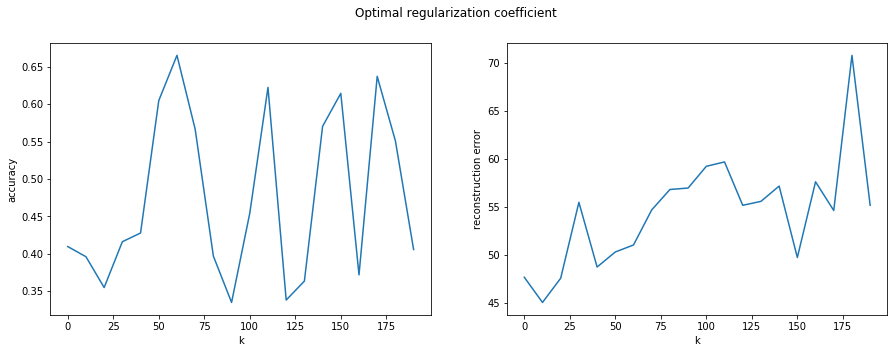

In [19]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(15, 5))
fig.suptitle("Optimal regularization coefficient")
plt.subplot(1,2,1)
x = ks
plt.plot(x, accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")

plt.subplot(1,2,2)
x = ks
plt.plot(x, val_losses)
plt.xlabel("k")
plt.ylabel("reconstruction error")

plt.savefig("/scratch/cs/csb/projects/single-cell-analysis/FCM/AML_FCM/Results/fcvae1_optimal_k.jpg", dpi=300)

## 7. Simulated data

In [1]:
from fcvae_simulate import simulate, plot_latent, plot_x
import numpy as np

# Simulate data
N_cells_per_cluster = 200
N_clusters = 5
x, z, labs = simulate(N_cells_per_cluster, N_clusters)

# Visualize full data
plot_latent(z, labs)
plot_x(x, z)

# After this, one could create multi-tube data from the full x by splitting the cells between tubes
n_cells_total = x.shape[0]
indices = np.random.permutation(n_cells_total)
n_cells_tube1 = 500
i1 = indices[0:n_cells_tube1]
i2 = indices[n_cells_tube1:n_cells_total]
x_tube1 = x[i1, :]
x_tube2 = x[i2, :]

# Censor some dimensions of x in different tubes (8 first shared)
x_tube1 = x_tube1[:, [0, 1, 2, 3, 4, 5, 6, 7,     8,  9, 10, 11]]
x_tube2 = x_tube2[:, [0, 1, 2, 3, 4, 5, 6, 7,    12, 13, 14, 15]]
print(x_tube1.shape)
print(x_tube2.shape)

<Figure size 600x600 with 1 Axes>

<Figure size 1000x800 with 32 Axes>

(500, 12)
(500, 12)
